In [179]:
import numpy as np
import pandas as pd

In [180]:
# --- 1.lOADING THE DATA ---
#Adjust the paths to match where you've unzipped "UCI HAR Dataset"

PATH = "/Users/ahmed/Desktop/Artificial-Intelligence-Coursework/UCI HAR Dataset"

features_path = PATH + "/features.txt"
activity_labels_path = PATH + "/activity_labels.txt"
X_train_path = PATH + "/train/X_train.txt"
y_train_path = PATH + "/train/y_train.txt"
X_test_path = PATH + "/test/X_test.txt"
y_test_path = PATH + "/test/y_test.txt"



In [181]:
# Load feature names, This appends the column index to any duplicate names.

features_df = pd.read_csv(features_path, sep="\s+", header=None, names=["idx", "feature"])
feature_names = features_df["feature"].tolist()


# his appends the column index to any duplicate names.
features_df["feature"] = features_df["feature"].astype(str) + "_" + features_df.index.astype(str)
feature_names = features_df["feature"].tolist()


# Load activity labels (mapping IDs 1-6 to string names)
activity_labels_df = pd.read_csv(activity_labels_path, sep="\s+", header=None, names=["id", "activity"])
activity_map = dict(zip(activity_labels_df["id"], activity_labels_df["activity"]))

In [182]:
#Load the training data
X_train = pd.read_csv(X_train_path, sep="\s+", header=None, names=feature_names)
y_train = pd.read_csv(y_train_path, sep="\s+", header=None, names=["activity"])
X_test = pd.read_csv(X_test_path, sep="\s+", header=None, names=feature_names)
y_test = pd.read_csv(y_test_path, sep="\s+", header=None, names=["activity"])

In [183]:
#Map activity IDs to their names
y_train["activity"] = y_train["activity"].map(activity_map)
y_test["activity"] = y_test["activity"].map(activity_map)


In [184]:
 # ---2.CONVERT MULTI-CLASS LABELS TO BINARY ---
def to_binary_label(activity):
    if activity in ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]:
        return 1 #Active
    else:
        return 0 #Inactive
    
y_train_binary = y_train["activity"].apply(to_binary_label)
y_test_binary = y_test["activity"].apply(to_binary_label)


#y_train_binary = y_train_binary.astype(int).values.ravel()
#y_test_binary = y_test_binary.astype(int).values.ravel()
#Now we have 0/1 labels in y_train["Binary"] and y_test["Binary"]


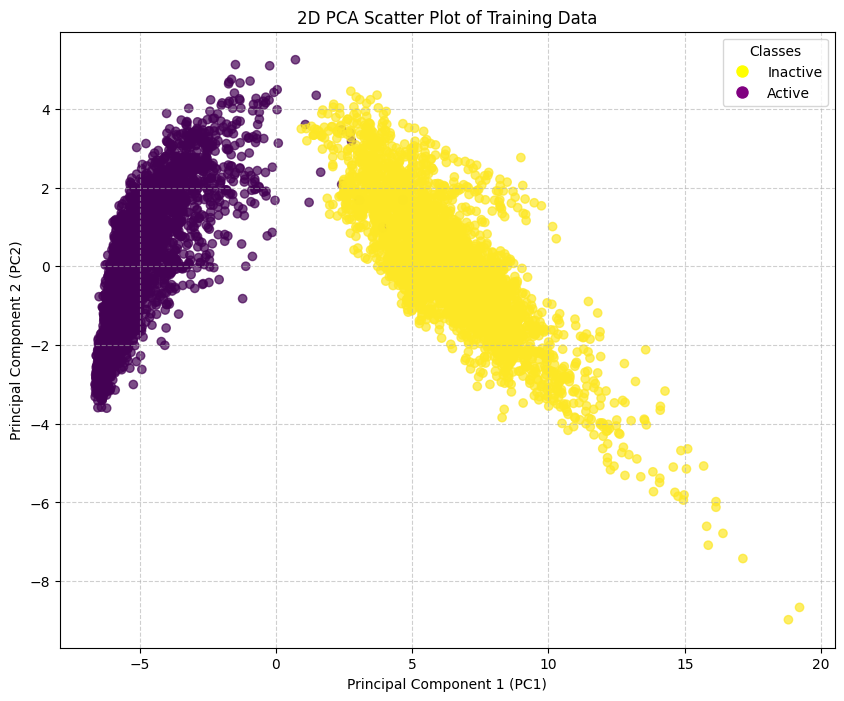

In [185]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensions of the data to 2 for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train_binary, cmap='viridis', alpha=0.7)

# Add title and labels
plt.title('2D PCA Scatter Plot of Training Data')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend for binary classes
class_labels = {0: 'Inactive', 1: 'Active'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label=class_labels[0]),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label=class_labels[1])]
plt.legend(handles=handles, title="Classes", loc='upper right')


plt.show()

In [186]:
#Reduction of the number of features
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=50)), #reduce from 561 -> 50 
    ("svm", SVC(class_weight="balanced"))
])

#can tweak n components depending on how much dimension reduction you want vs how much#
#computational time you can spare

In [187]:
#Evaluate the model
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

pipeline.fit(X_train, y_train_binary)
y_pred = pipeline.predict(X_test)

f1 = f1_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)

print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

F1 Score: 1.00
Precision: 1.00
Recall: 1.00


In [188]:
#training the baseline svm models with different kernels (linear, polynomial, rbf)
param_grid = [
    {
        "svm__kernel": ["linear"],
        "svm__C":  [0.001, 0.01, 0.1, 1, 10]
    },
    {
        "svm__kernel": ["poly"],
        "svm__degree": [2, 3, 4, 5], #only relevant for the poly kernel
        "svm__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
        "svm__C":  [0.001, 0.01, 0.1, 1, 10]
    },
    {
        "svm__kernel": ["rbf"],
        "svm__C":  [0.001, 0.01, 0.1, 1, 10],
        "svm__gamma": [1, 0.1, 0.01, 0.001, 0.0001]
    }
]

In [ ]:
'''
#grid search (took a while to run)
duration : 17m 52.6s
Output:
KeyboardInterrupt                         Traceback (most recent call last)
Cell In[136], line 12
      2 from sklearn.model_selection import GridSearchCV
      3 grid_search = GridSearchCV(
      4     estimator=pipeline,
      5     param_grid=param_grid,
   (...)      9     verbose=1
     10 )
---> 12 grid_search.fit(X_train, y_train_binary)
     13 print("Best parameters: ", grid_search.best_params_)
     14 print("Best score: ", grid_search.best_score_)

File ~\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389, in _fit_context.<locals>.decorator.<locals>.wrapper(estimator, *args, **kwargs)
   1382     estimator._validate_params()
   1384 with config_context(
   1385     skip_parameter_validation=(
   1386         prefer_skip_nested_validation or global_skip_validation
   1387     )
   1388 ):
-> 1389     return fit_method(estimator, *args, **kwargs)

File ~\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1024, in BaseSearchCV.fit(self, X, y, **params)
   1018     results = self._format_results(
      1019         all_candidate_params, n_splits, all_out, all_more_results
...
   1765 # We need to be careful: the job list can be filling up as
   1766 # we empty it and Python list are not thread-safe by
   1767 # default hence the use of the lock

KeyboardInterrupt: 
--------------------------------------------------------------------------------------------------------------------------

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=2,
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train_binary)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
'''

'\n#grid search (took a while to run)\nduration : 17m 52.6s\nOutput:\nKeyboardInterrupt                         Traceback (most recent call last)\nCell In[136], line 12\n      2 from sklearn.model_selection import GridSearchCV\n      3 grid_search = GridSearchCV(\n      4     estimator=pipeline,\n      5     param_grid=param_grid,\n   (...)      9     verbose=1\n     10 )\n---> 12 grid_search.fit(X_train, y_train_binary)\n     13 print("Best parameters: ", grid_search.best_params_)\n     14 print("Best score: ", grid_search.best_score_)\n\nFile ~\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\sklearn\x08ase.py:1389, in _fit_context.<locals>.decorator.<locals>.wrapper(estimator, *args, **kwargs)\n   1382     estimator._validate_params()\n   1384 with config_context(\n   1385     skip_parameter_validation=(\n   1386         prefer_skip_nested_validation or global_skip_validation\n   1387     )\n   1388 

In [190]:
#it took too long, so we are going do a RandomizedSearchCV instead
from sklearn.model_selection import RandomizedSearchCV


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train_binary)
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'svm__kernel': 'rbf', 'svm__gamma': 0.001, 'svm__C': 1}
Best score:  0.9997280761386811


In [191]:
from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = random_search.predict(X_test)


conf_matrix = confusion_matrix(y_test_binary, y_pred)
print(conf_matrix)


print(classification_report(y_test_binary, y_pred))

[[1559    1]
 [   0 1387]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1560
           1       1.00      1.00      1.00      1387

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947

